In [41]:
import pandas as pd
import pymongo
import requests
from bs4 import BeautifulSoup
import time
import json
from collections import Counter
from sklearn.model_selection import train_test_split

In [2]:
mc = pymongo.MongoClient()  # Connect to the MongoDB server using default settings
db = mc['chess_predictions']  # Use (or create) a database called 'chess_predictions'
players = db['players']  # Use (or create) a collection called 'players'

In [11]:
def get_player_profile(username):
    try:
        response = requests.get(f'https://api.chess.com/pub/player/{username}')
        return json.loads(response.content.decode('utf-8'))
    except:
        return [] 
        
def get_player_stats(username):
    try:
        response = requests.get(f'https://api.chess.com/pub/player/{username}/stats')
        return json.loads(response.content.decode('utf-8'))
    except:
        return []
        
def get_player_games(username):
    '''return a list of lists where each list contains the games played for each month January through May 2018'''
    
    months = ['01', '02', '03', '04', '05']
    month_games = []
    for month in months:
        try:
            response = requests.get(f'https://api.chess.com/pub/player/{username}/games/2018/{month}')
            month_games.append([json.loads(response.content.decode('utf-8'))])
        except:
            continue
    return month_games

def player_data_to_mongoDB(username, mongoDB_connection, database, collection):
    
    mc = mongoDB_connection
    
    #use/create a database
    db = mc[database]
    
    #use/create a collection
    collection = db[collection]
    
    #query Chess.com api for data
    profile = get_player_profile(username)
    stats = get_player_stats(username)
    games = get_player_games(username)
    
    #insert player data into database
    collection.insert_one({**profile,
                           **stats,
                           'games': games
                            })

def all_player_data_to_mongoDB(players, mongoDB_connection, database, collection, verbose=False):
    '''insert all player data into a mongoDB
       Params:
          players: list of player names
          mongoDB_connection: open connection to database ex. pymongo.MongoClient()
          database: name of database
          collection: name of collection
       Keyword Args:
          verbose: if True print player name after each insert, default is False
    '''
    for player in players:
        player_data_to_mongoDB(player, mongoDB_connection, database, collection)
        if verbose:
            print(player)

In [215]:
df_test = pd.DataFrame(list(db['players_testrun'].find()))
df_test.head()

,@id,_id,avatar,chess960_daily,chess_blitz,chess_bullet,chess_daily,chess_rapid,country,followers,games,joined,last_online,location,name,player_id,status,url,username
0,https://api.chess.com/pub/player/dandorsky,5afcae640983880d0e0685d1,NaN,NaN,"{'last': {'rating': 340, 'date': 1515648394, '...",NaN,NaN,"{'last': {'rating': 724, 'date': 1526499189, '...",https://api.chess.com/pub/country/US,0,[[{'games': [{'url': 'https://www.chess.com/li...,1515644628,1526484310,NaN,Daniel Andorsky,42205128,basic,https://www.chess.com/member/dandorsky,dandorsky
1,https://api.chess.com/pub/player/crescendoluke,5afcae680983880d0e0685d2,NaN,NaN,"{'last': {'rating': 1031, 'date': 1526306312, ...",NaN,"{'last': {'rating': 1241, 'date': 1526357722, ...",NaN,https://api.chess.com/pub/country/US,2,[[{'games': [{'url': 'https://www.chess.com/li...,1517006739,1526475349,NaN,NaN,42721680,basic,https://www.chess.com/member/crescendoluke,crescendoluke
2,https://api.chess.com/pub/player/tingui234,5afcae700983880d0e0685d3,https://images.chesscomfiles.com/uploads/v1/us...,NaN,"{'last': {'rating': 1354, 'date': 1526506067, ...","{'last': {'rating': 971, 'date': 1526405785, '...","{'last': {'rating': 800, 'date': 1520370612, '...","{'last': {'rating': 1202, 'date': 1524595590, ...",https://api.chess.com/pub/country/US,4,[[{'games': [{'url': 'https://www.chess.com/li...,1517019079,1526504370,NaN,NaN,42725688,basic,https://www.chess.com/member/tingui234,tingui234
3,https://api.chess.com/pub/player/lumin0us,5afcae7a0983880d0e0685d4,NaN,NaN,"{'last': {'rating': 1527, 'date': 1526415123, ...",NaN,NaN,NaN,https://api.chess.com/pub/country/US,1,[[{'games': [{'url': 'https://www.chess.com/li...,1514945720,1526478610,NaN,A M,41944824,basic,https://www.chess.com/member/lumin0us,lumin0us
4,https://api.chess.com/pub/player/rwoodburn,5afcae7e0983880d0e0685d5,NaN,NaN,NaN,NaN,NaN,"{'last': {'rating': 1130, 'date': 1523982411, ...",https://api.chess.com/pub/country/US,0,"[[{'games': []}], [{'games': []}], [{'games': ...",1515061721,1526405774,NaN,NaN,41985938,basic,https://www.chess.com/member/rwoodburn,rwoodburn


In [217]:
df_test.joined.max()

1517442624

In [218]:
#get data from mongoDB and put into dataframe
df = pd.DataFrame(list(db['players_testrun'].find()))

print('done importing from mongoDB')

#remove duplicate users by player_id
df.drop_duplicates(subset='player_id', inplace=True)

#reset the index
df.reset_index(drop=True, inplace=True)

print('now making X and y')

#create features and target
X, y = make_X_and_y(df)

#make a train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

random_forest_testrun = RandomForestClassifier()
random_forest_testrun.fit(X_train, y_train)
y_predict = random_forest_testrun.predict_proba(X_test)

print(roc_auc_score(y_test, y_predict[:, 1]))

print('all done my dude!')

done importing from mongoDB
now making X and y
all done my dude!


In [242]:
random_forest_testrun = RandomForestClassifier()
random_forest_testrun.fit(X_train, y_train)
y_predict = random_forest_testrun.predict_proba(X_test)

print(roc_auc_score(y_test, y_predict[:, 1]))

0.8860095389507154


In [221]:
X_train.iloc[:, :10].columns

Index(['followers', 'joined', 'A00', 'A01', 'A02', 'A03', 'A04', 'A05', 'A06',
       'A07'],
      dtype='object')

In [170]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split, cross_val_score

random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)
y_predict = random_forest.predict_proba(X_test)

roc_auc_score(y_test, y_predict[:, 1])

cross_val_score(random_forest, X_test, y_test, cv=20)

0.82421740626075

In [166]:
def plot_roc(model, x_columns, y_true):

    y_pred = model.predict_proba(x_columns)

    fpr, tpr, threshold = roc_curve(y_true, y_pred[:,1])
    area_under_curve = auc(fpr, tpr)

    # method I: plt
    fig, ax = plt.subplots()
    model_name = str(type(model)).split('.')[-1].strip(">\'")
    plt.title(f'{model_name} ROC')
    ax.plot(fpr, tpr, 'k', label = 'C AUC = %0.3f' % area_under_curve)

    ax.legend(loc = 'lower right')
    ax.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

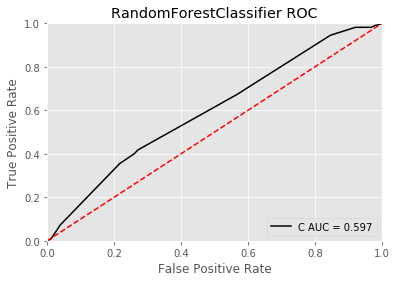

In [212]:
random_forest_rated = RandomForestClassifier()
random_forest_rated.fit(X_train[['has_name',
       'has_location', 'has_avatar', 'is_basic', 'is_premium']], y_train)
plot_roc(random_forest_rated, X_test[['has_name',
       'has_location', 'has_avatar', 'is_basic', 'is_premium']], y_test)

values, features = rf_best_features(X_test[['has_name',
       'has_location', 'has_avatar', 'is_basic', 'is_premium']], y_test, 5)
plot_best_features(values, features)

In [180]:
def rf_best_features(X, y, n_features):
    
    x_columns = X

    y_true = y

    rf_model = RandomForestClassifier(n_estimators=100)
    
    rf_model.fit(x_columns, y_true)
    
    feature_importances = {}
    
    for i in range(len(rf_model.feature_importances_)):
        
        feature_importances[x_columns.columns[i]] = rf_model.feature_importances_[i]
    
    
    top_features = Counter(feature_importances).most_common(n_features)
    
    values = [feature[1] for feature in top_features]
    
    features = [feature[0] for feature in top_features]
    
    return values, features


def plot_best_features(values, features, figsize_x=10, figsize_y=10):
    
    new_df = pd.DataFrame(list(zip(values,features))).set_index(1).sort_values(0)

    new_df.plot.barh(figsize=(figsize_x,figsize_y))

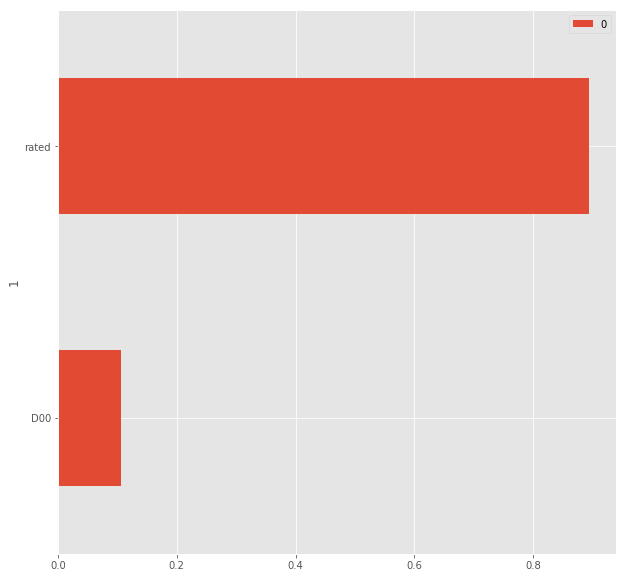

In [173]:
values, features = rf_best_features(X_test[['rated', 'D00']], y_test, 26)
plot_best_features(values, features)

In [114]:
def games_in_a_month(games_column, player, month):
    return len(games_column[player][month][0]['games'])
    
def rated_games(games_column, player, month, game):
    return str(games_column[player][month][0]['games'][game]['rated'])

def time_class_games(games_column, player, month, game):
    return games_column[player][month][0]['games'][game]['time_class']

def rules_games(games_column, player, month, game):
    return games_column[player][month][0]['games'][game]['rules']

def eco_games(games_column, player, month, game):
    return games_column[player][month][0]['games'][game]['eco'][31:].split('-')[0]

def results_games(games_column, player, month, game):
    if games_column[player][month][0]['games'][game]['white'] == df.username[0]:
        return games_column[player][month][0]['games'][game]['white']['result']
    else:
        return games_column[player][month][0]['games'][game]['black']['result']

def make_columns(features, df, index):
    '''Counts the appearances of each type of outcome then creates a column in the dataframe corresponding to
    that outcome and filling in the number of occurrences for each player
    Params:
        features: List of each outcome ex: [c, a, a, d, d, a, d, c, j]
        df: pandas dataframe
        index: index to located each player
    '''
    counters = Counter()
    for feature in features:
        counters[feature] += 1

    for counter in counters:
        df.loc[index, counter] = counters[counter]


def parse_games(df, column='games', verbose=False):
    '''Pull out stats from the column containing games and add columns to the datafram inplace for the stats
    Params:
        df: pandas dataframe
    Keyword Args:
        column: column containing games, default column name is 'games'
        verbose: if True, print player indices as they are parsed, default is False
    '''
    games_column = df[column]
    player_idx = range(df.shape[0])
    for player in player_idx:
        if verbose:
            print(player)
        rated = []
        time_class = []
        rules = []
        eco = []
        results = []
        if len(games_column[player]) != 5:
            continue
        else:
            for month in range(4):
                try:
                    for game in range(games_in_a_month(games_column, player, month)):
                        try:
                            rated.append(rated_games(games_column, player, month, game))
                        except KeyError:
                            continue
                        try:
                            time_class.append(time_class_games(games_column, player, month, game))
                        except KeyError:
                            continue
                        try:
                            rules.append(rules_games(games_column, player, month, game))
                        except KeyError:
                            continue
                        try:
                            eco.append(eco_games(games_column, player, month, game))
                        except KeyError:
                            continue
                        try:
                            results.append(results_games(games_column, player, month, game))
                        except KeyError:
                            continue
                except KeyError:
                    continue
                    
            df.loc[player, 'may_games'] = games_in_a_month(games_column, player, 4)
            
            make_columns(time_class, df, player)
            make_columns(rated, df, player)
            make_columns(rules, df, player)
            make_columns(eco, df, player)
            make_columns(results, df, player)
            
def init_columns(df):
    '''Add columns for all eco codes, rated games, time_class, rules
    Params:
        df: pandas dataframe
    '''
    labels = ['A00', 'A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09',
               'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19',
               'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29',
               'A30', 'A31', 'A32', 'A33', 'A34', 'A35', 'A36', 'A37', 'A38', 'A39',
               'A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46', 'A47', 'A48', 'A49',
               'A50', 'A51', 'A52', 'A53', 'A54', 'A55', 'A56', 'A57', 'A58', 'A59',
               'A60', 'A61', 'A62', 'A63', 'A64', 'A65', 'A66', 'A67', 'A68', 'A69',
               'A70', 'A71', 'A72', 'A73', 'A74', 'A75', 'A76', 'A77', 'A78', 'A79',
               'A80', 'A81', 'A82', 'A83', 'A84', 'A85', 'A86', 'A87', 'A88', 'A89',
               'A90', 'A91', 'A92', 'A93', 'A94', 'A95', 'A96', 'A97', 'A98', 'A99',
               'B00', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09',
               'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16', 'B17', 'B18', 'B19',
               'B20', 'B21', 'B22', 'B23', 'B24', 'B25', 'B26', 'B27', 'B28', 'B29',
               'B30', 'B31', 'B32', 'B33', 'B34', 'B35', 'B36', 'B37', 'B38', 'B39',
               'B40', 'B41', 'B42', 'B43', 'B44', 'B45', 'B46', 'B47', 'B48', 'B49',
               'B50', 'B51', 'B52', 'B53', 'B54', 'B55', 'B56', 'B57', 'B58', 'B59',
               'B60', 'B61', 'B62', 'B63', 'B64', 'B65', 'B66', 'B67', 'B68', 'B69',
               'B70', 'B71', 'B72', 'B73', 'B74', 'B75', 'B76', 'B77', 'B78', 'B79',
               'B80', 'B81', 'B82', 'B83', 'B84', 'B85', 'B86', 'B87', 'B88', 'B89',
               'B90', 'B91', 'B92', 'B93', 'B94', 'B95', 'B96', 'B97', 'B98', 'B99',
               'C00', 'C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09',
               'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19',
               'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29',
               'C30', 'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39',
               'C40', 'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49',
               'C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59',
               'C60', 'C61', 'C62', 'C63', 'C64', 'C65', 'C66', 'C67', 'C68', 'C69',
               'C70', 'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79',
               'C80', 'C81', 'C82', 'C83', 'C84', 'C85', 'C86', 'C87', 'C88', 'C89',
               'C90', 'C91', 'C92', 'C93', 'C94', 'C95', 'C96', 'C97', 'C98', 'C99',
               'D00', 'D01', 'D02', 'D03', 'D04', 'D05', 'D06', 'D07', 'D08', 'D09',
               'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'D16', 'D17', 'D18', 'D19',
               'D20', 'D21', 'D22', 'D23', 'D24', 'D25', 'D26', 'D27', 'D28', 'D29',
               'D30', 'D31', 'D32', 'D33', 'D34', 'D35', 'D36', 'D37', 'D38', 'D39',
               'D40', 'D41', 'D42', 'D43', 'D44', 'D45', 'D46', 'D47', 'D48', 'D49',
               'D50', 'D51', 'D52', 'D53', 'D54', 'D55', 'D56', 'D57', 'D58', 'D59',
               'D60', 'D61', 'D62', 'D63', 'D64', 'D65', 'D66', 'D67', 'D68', 'D69',
               'D70', 'D71', 'D72', 'D73', 'D74', 'D75', 'D76', 'D77', 'D78', 'D79',
               'D80', 'D81', 'D82', 'D83', 'D84', 'D85', 'D86', 'D87', 'D88', 'D89',
               'D90', 'D91', 'D92', 'D93', 'D94', 'D95', 'D96', 'D97', 'D98', 'D99',
               'E00', 'E01', 'E02', 'E03', 'E04', 'E05', 'E06', 'E07', 'E08', 'E09',
               'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19',
               'E20', 'E21', 'E22', 'E23', 'E24', 'E25', 'E26', 'E27', 'E28', 'E29',
               'E30', 'E31', 'E32', 'E33', 'E34', 'E35', 'E36', 'E37', 'E38', 'E39',
               'E40', 'E41', 'E42', 'E43', 'E44', 'E45', 'E46', 'E47', 'E48', 'E49',
               'E50', 'E51', 'E52', 'E53', 'E54', 'E55', 'E56', 'E57', 'E58', 'E59',
               'E60', 'E61', 'E62', 'E63', 'E64', 'E65', 'E66', 'E67', 'E68', 'E69',
               'E70', 'E71', 'E72', 'E73', 'E74', 'E75', 'E76', 'E77', 'E78', 'E79',
               'E80', 'E81', 'E82', 'E83', 'E84', 'E85', 'E86', 'E87', 'E88', 'E89',
               'E90', 'E91', 'E92', 'E93', 'E94', 'E95', 'E96', 'E97', 'E98', 'E99',
               'win', 'checkmated', 'agreed', 'repetition', 'timeout', 'resigned', 
               'stalemate', 'lose', 'insufficient', '50move', 'abandoned', 'kingofthehill',
               'threecheck', 'timevsinsufficient', 'bughousepartnerlose', 'False', 'True',
               'standard', 'daily', 'blitz', 'lightning', 'chess960', 'crazyhouse', 'bughouse', 'chess']
    for label in labels:
        df[label] = 0
        
def make_X_and_y(df):
    '''make all feature columns and target column
    Params:
        df: pandas datafram
    Returns:
        X: all important feature columns
        y: target column, 1 (inactive: less than 2 games played during the last month) or 0 (active)
    '''
    #initialize columns
    init_columns(df)

    #parse games column
    parse_games(df)
    
    #rename True and False columns to rated and unrated
    df.rename(columns={'True': 'rated', 'False': 'unrated'}, inplace=True)

    #create inactive column (1 = inactive, 0 = active) inactive if they have not played a game in two weeks (may 1st)
    def is_inactive(x):
        '''checks if value is less than 2
        '''
        if x < 2:
            return 1
        else:
            return 0

    df['inactive'] = df['may_games'].apply(lambda x: is_inactive(x))

    #create columns has_name, has_location, has_avatar
    def has_attribute(x):
        if x != x:
            return 0
        else:
            return 1

    df['has_name'] = df['name'].apply(lambda x: has_attribute(x))
    df['has_location'] = df['location'].apply(lambda x: has_attribute(x))
    df['has_avatar'] = df['avatar'].apply(lambda x: has_attribute(x))

    #make a basic account type column
    def is_basic(x):
        '''check if value is the string basic'''
        if x == 'basic':
            return 1
        else:
            return 0

    df['is_basic'] = df['status'].apply(lambda x: is_basic(x))

    #make a premium account type column
    def is_premium(x):
        '''check if value is the string premium'''
        if x == 'premium':
            return 1
        else:
            return 0

    df['is_premium'] = df['status'].apply(lambda x: is_premium(x))
    
    #assign X and y variables
    y = df['inactive']
    
    X = df.drop(columns=['@id', '_id', 'avatar', 'chess960_daily', 'chess_blitz',
                         'chess_bullet', 'chess_daily', 'chess_rapid', 'country',
                         'games', 'last_online', 'location', 'name', 'player_id',
                         'status', 'url', 'username', 'may_games', 'inactive'])
    
    return (X, y)

In [113]:
df[['rated', 'unrated']].head()

,rated,unrated
0,33,0
1,823,830
2,0,0
3,6,0
4,285,114


In [135]:
df.drop(labels=['standard', 'daily', 'blitz', 'lightning'],axis=1, inplace=True)

In [137]:
df.drop(labels=['True', 'False'],axis=1, inplace=True)

In [ ]:
df['games'][player][month][0]['games'][one game from the month]['url',
                                                                'pgn',
                                                                'time_control',
                                                                'end_time',
                                                                'rated',
                                                                'fen',
                                                                'time_class',
                                                                'rules',
                                                                'white',
                                                                'black']


In [232]:
letters = ['A', 'B', 'C', 'D', 'E']
nums = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
eco_codes = []
for letter in letters:
    for num in nums:
        for num2 in nums:
            eco_codes.append(letter + num + num2)
print(eco_codes)

['A00', 'A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'A33', 'A34', 'A35', 'A36', 'A37', 'A38', 'A39', 'A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46', 'A47', 'A48', 'A49', 'A50', 'A51', 'A52', 'A53', 'A54', 'A55', 'A56', 'A57', 'A58', 'A59', 'A60', 'A61', 'A62', 'A63', 'A64', 'A65', 'A66', 'A67', 'A68', 'A69', 'A70', 'A71', 'A72', 'A73', 'A74', 'A75', 'A76', 'A77', 'A78', 'A79', 'A80', 'A81', 'A82', 'A83', 'A84', 'A85', 'A86', 'A87', 'A88', 'A89', 'A90', 'A91', 'A92', 'A93', 'A94', 'A95', 'A96', 'A97', 'A98', 'A99', 'B00', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16', 'B17', 'B18', 'B19', 'B20', 'B21', 'B22', 'B23', 'B24', 'B25', 'B26', 'B27', 'B28', 'B29', 'B30', 'B31', 'B32', 'B33', 'B34', 'B35', 'B36', 'B37', 'B38', 'B39', 'B40', 'B41', 'B42'

In [ ]:
df_2017 = pd.DataFrame(list(db['2017players'].find()))
df_2017.head()